# Implementing DCA in pytorch

Source CC function in [seqmodel](https://github.com/sokrypton/seqmodels/blob/master/seqmodels.ipynb)
Reimplemeting tensorflow code in pytorch. We will try to stick with the same variables as seqmodels.

In [1]:
import torch

import read_config
from dataloader import MSADataset, OneHotTransform

In [2]:
config = read_config.Config("../config_dca.yaml")
dataset = MSADataset(config.aligned_msa_fullpath, transform=OneHotTransform(21, flatten=False))

N = len(dataset)

protein_seq, weight = dataset[0]
ncat = 21
L = protein_seq.shape[0]
ncol = L

N, L

(14441, 559)

In [3]:
protein_seq.shape

torch.Size([559, 21])

In [4]:
ncol, ncat

(559, 21)

In [5]:
batch_size = config.batch_size
if batch_size <= 0:
    batch_size = N # entire dataset in one batch
msa = torch.utils.data.DataLoader(dataset, batch_size)

for _, msa_data in enumerate(msa):
    msa  = msa_data[0]
    msa_weights = msa_data[1]
    break
    
print(f"Data.shape = {msa.shape}")
print(f"Weights.shape = {msa_weights.shape}")

Data.shape = torch.Size([14441, 559, 21])
Weights.shape = torch.Size([14441])


In [6]:
device = config.device

In [7]:
msa_cat = msa.argmax(dim=2) # type LongTensor

msa = msa.to(device)
msa_cat = msa_cat.to(device)
msa_weights= msa_weights.to(device)

In [8]:
class DCA(torch.nn.Module):
    
    def __init__(self, Neff, ncol, lam_w=0.01, lam_b=0.01, b_ini=None):
        super().__init__()
        # weights
        self.w = torch.nn.Parameter(torch.zeros((ncol, ncat, ncol, ncat), 
                        dtype=torch.float, requires_grad=True))
        # biases
        if b_ini is None:
            b_ini = torch.zeros((ncol, ncat), dtype=torch.float)
        self.bias = torch.nn.Parameter(b_ini.clone().detach().requires_grad_(True))

        self.Neff = Neff
        self.lam_w = lam_w
        self.lam_b = lam_b
        self.ncol = ncol
        #self.weights = None
        
    def forward(self, x):
        """Predictions are going to be MSA logits
            We also calculate the regularization penalties here (FIXME)
        """
        x_msa = x
        # we do not want weights between the various nodes in a given position. 
        # i.e. weights between nodes (i, a) and (j, b) only exist if i not = j
        # so set these weights to zero
        w_eye = self.w * torch.reshape(1 - torch.eye(self.ncol), 
                                       (self.ncol,1,self.ncol, 1))
        # symmetrize w so that the weight between (i,a) and (j, b) is the
        # same as the weight between (j, b) and (i, a)
        self.weights = w_eye + w_eye.permute(2,3,0,1)
        x_logit = torch.tensordot(x_msa, self.weights, 2) + self.bias
        return x_logit 

    def calc_reg_w(self):
        return self.lam_w * \
                    torch.sum(torch.mul(self.weights, self.weights)) * \
                    0.5 * (self.ncol-1) * 20.0 
    
    def calc_reg_b(self):
        return self.lam_b * torch.sum(torch.mul(self.bias, self.bias))
    
    def create_dca_model(msa, msa_weights, device):
        """Factory function to create a model with a pseudocount bias term"""

        with torch.no_grad():
            msa = msa.to(device)
            msa_weights = msa_weights.to(device)

            # Integer representation of protein (instead of one-hot)
            # Here each protein is represented as a number from 0 - 20
            # We need this for crossentropy
            msa_cat = msa.argmax(dim=2) # type LongTensor

            # Number of effective sequences
            Neff = torch.sum(msa_weights) 

            # start bias with b_ini instead of zeros
            pseudo_count = 0.01 * torch.log(Neff)
            b_ini = torch.log(torch.sum(msa.T * msa_weights, axis=-1).T + pseudo_count)
            b_ini = b_ini - torch.mean(b_ini, -1, keepdim=True)
            
            return DCA(Neff=Neff, ncol=ncol, b_ini=b_ini)
    
model = DCA.create_dca_model(msa, msa_weights, device)
model.to(device)

# Tell the optimizer which weights we want to update
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [9]:
def create_loss_function():
    ce_loss_func = torch.nn.CrossEntropyLoss(reduction='none')
    
    def calc_loss(x_logit, x_cat, x_weights, model):
        loss_ce = ce_loss_func(x_logit.permute(0,2,1), x_cat)
        loss_ce = loss_ce.sum(dim=-1)
        loss_ce = (loss_ce * x_weights).sum()

        reg = model.calc_reg_w() + model.calc_reg_b()
    
        loss = (loss_ce + reg) / model.Neff
        return loss
    return calc_loss

In [10]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, x_weights, x_cat):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        x_logit = model(x)
        # Computes loss
        loss = loss_fn(x_logit, x_cat, x_weights, model)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

train_step = make_train_step(model, create_loss_function(), optimizer)

In [11]:
num_epochs = config.epochs
#num_epochs = 10
losses = []
for epoch in range(num_epochs):
    loss = train_step(msa, msa_weights, msa_cat)
    losses.append(loss)
    print(epoch, loss)

0 951.436279296875
1 787.1755981445312
2 690.6675415039062
3 628.7225341796875
4 585.6104125976562
5 554.2444458007812
6 530.35986328125
7 511.4407653808594
8 495.9153747558594
9 482.745849609375
10 471.2301330566406
11 461.0218200683594
12 451.8956298828125
13 443.6158752441406
14 436.03558349609375
15 429.0606689453125
16 422.61474609375
17 416.6512145996094
18 411.1168212890625
19 405.96746826171875
20 401.1649475097656
21 396.6786804199219
22 392.4954528808594
23 388.60504150390625
24 384.99456787109375
25 381.6486511230469
26 378.5497741699219
27 375.6768798828125
28 373.0081481933594
29 370.5240783691406
30 368.2079162597656
31 366.04315185546875
32 364.0150146484375
33 362.1128234863281
34 360.3292236328125
35 358.6579895019531
36 357.0929260253906
37 355.6273498535156
38 354.2540588378906
39 352.9657897949219
40 351.7550354003906
41 350.614501953125
42 349.5377197265625
43 348.51885986328125
44 347.5535888671875
45 346.63818359375
46 345.770263671875
47 344.9470520019531
48 344

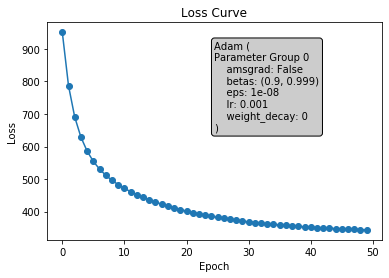

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses, "o-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
bbox = dict(boxstyle="round", fc="0.8")
plt.annotate(str(optimizer), (0.5, 0.5), xycoords='axes fraction',
            bbox=bbox);